
# AutoEncoder
- 입력데이터를 압축시켰다가, 다시 원본 데이터로 복원하는 과정 : 복원을 해야하기에 학습시에 원본 데이터의 가장 중요한 부분만 남기도록 압축
- 복원과정에서 Reconstruction Error를 최소화하면서 데이터를 압축하도록 훈련
- 데이터 압축, 노이즈 제거, 이상 탐지 등에 활용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


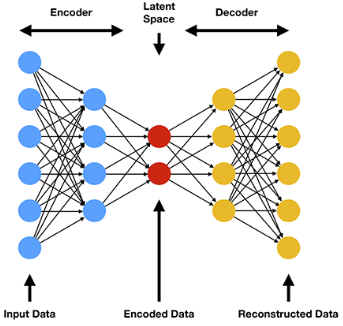

In [2]:
from IPython.display import Image
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/ae.png')

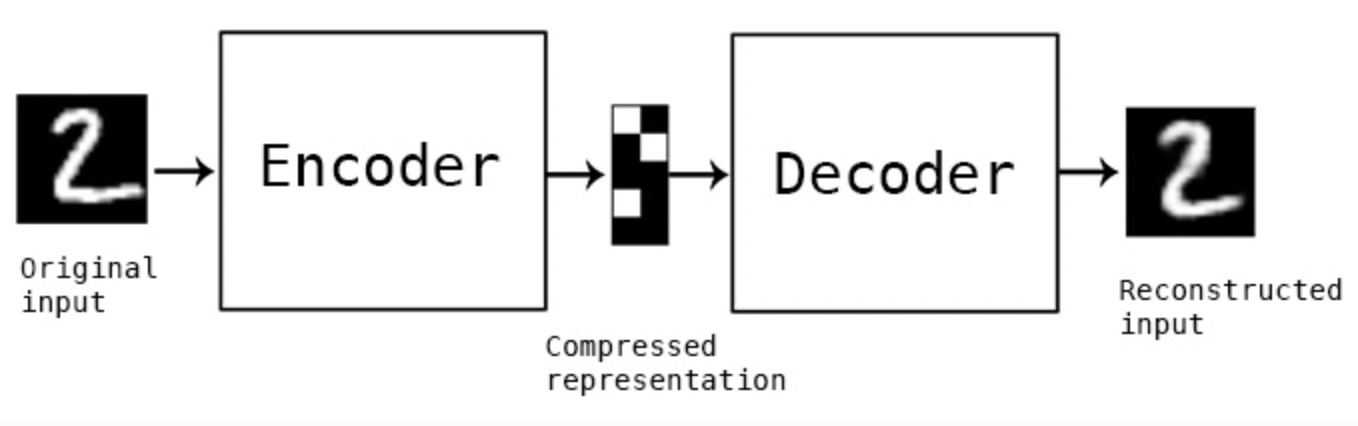

In [3]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/aes.png')

In [4]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
# 평가 지표로 활용하기 위해서.
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### Load dataset
- Fashion MNIST dataset 사용
- 각 이미지별 784(28*28)개의 픽셀 값이 존재

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


### Data Normalization
- [0, 255]의 값을 가지는 픽셀 → [0, 1]로 정규화

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# 1. Basic AutoEncoder

### Define Network
- Encoder: 784(28*28)차원의 Original image space에서 64차원의 Latent space로 압축
- Decoder: 압축된 Latent space를 이용해 Original image를 재구성

In [7]:
latent_dim = 64
# latent space 차원 지정
# class 쉬운 설명 : https://dojang.io/mod/page/view.php?id=2386

class Autoencoder(Model):
  # Model을 상속 : 이제까지는 Model 안에서 Dense, Conv 등을 따로 가져와서 사용했는데 이렇게 통째로 상속을 받으면 이안에서 전부 사용할 수 있다.
  def __init__(self, latent_dim):
    # 상속받은 Model의 메소드 그대로 사용
    super(Autoencoder, self).__init__() # 파생 클래스와 self : 없어도됨
    # super()로 기반 클래스의 __init__ 메서드 호출
    #  기반클래스 속성 사용가능 : 쉽게 이야기하면 이제부터 이 함수안에서 Dense, Flatten 사용가능
    
    self.latent_dim = latent_dim
    # 28*28차원의 픽셀 값을 784차원으로 펼치고 Dense layer를 통해 64차원의 latent vector로 압축
    self.encoder = tf.keras.Sequential([layers.Flatten(),
                                        layers.Dense(latent_dim, activation='relu')])
    # Dense layer를 통해 64차원의 latent vector를 784차원으로 재구축한 후 28*28차원의 픽셀 값으로 Reshape
    self.decoder = tf.keras.Sequential([layers.Dense(784, activation='sigmoid'),
                                        layers.Reshape((28, 28))])
    
  def call(self, x): # forward 함수 : class를 선언하면 자동으로 모델을 아래와 같이 정의.
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Train Model
- 입력 데이터로 재구축하는 것이 목적인 Reconstruction Model이기 때문에 Input과 Target 모두 x_train

In [9]:
# 입력하는 데이터 x_train이 x_train과 가깝게 복원되도록 학습해야하기에 y도 x_train이다.
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 0.0235 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.008

In [10]:
autoencoder.encoder.summary()

# 총 parameter 수: 784개의 node와 64개의 node를 연결하는 weight들의 개수 (784*64) + 64개 노드의 bias 개수 (64) 
print('784 * 64 + 64 =', 784 * 64 + 64, 'params')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________
784 * 64 + 64 = 50240 params


In [11]:
autoencoder.decoder.summary()

# 총 parameter 수: 64개의 node와 784개의 node를 연결하는 weight들의 개수 (784*64) + 784개 노드의 bias 개수 (784)
print('64 * 784 + 784 =', 64 * 784 + 784, 'params')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________
64 * 784 + 784 = 50960 params


### Test Model
- Test Data를 Train된 Model에 넣어보고 재구축된 이미지 시각화

In [12]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
# x_test 이미지를 encoder에 입력 : latent space
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# 위에서 압축한 latent vector를 decoder에 다시 입력 : 복원된 이미지

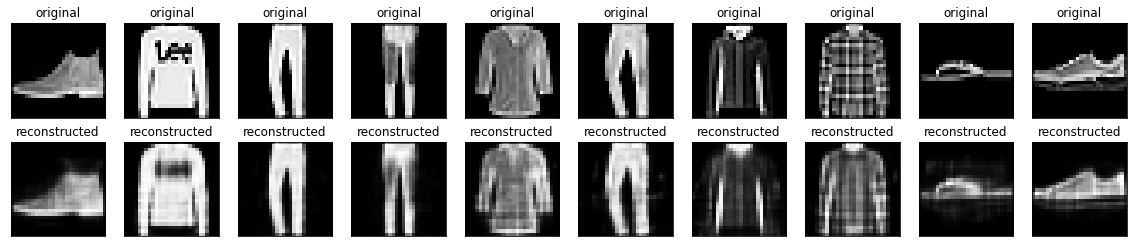

In [13]:
n = 10
# 10장만 sample로 보여준다.
plt.figure(figsize=(20, 4))

for i in range(n):
    
    # Original Image 시각화
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    # 실제 이미지 먼저 시각화
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # 축없애기

    # Reconstructed Image 시각화
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    # 여기서는 위의 모델을 통과하여 복원한 이미지를 입력
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 2. Deep AutoEncoder

### Define Network

In [14]:
# 층을 더 깊이 쌓은 Autoencoder
class DeepAutoencoder(Model):

  def __init__(self, latent_dim):
    super(DeepAutoencoder, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(196, activation='relu'),
      layers.Dense(49, activation='relu'),
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(196, activation='relu'),
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

deepautoencoder = DeepAutoencoder(latent_dim)

In [15]:
deepautoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Train Model

In [16]:
deepautoencoder.fit(x_train, x_train,
                    epochs=10,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0213 - val_loss: 0.0138
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.008

### Test Model

In [17]:
deep_encoded_imgs = deepautoencoder.encoder(x_test).numpy()
deep_decoded_imgs = deepautoencoder.decoder(deep_encoded_imgs).numpy()

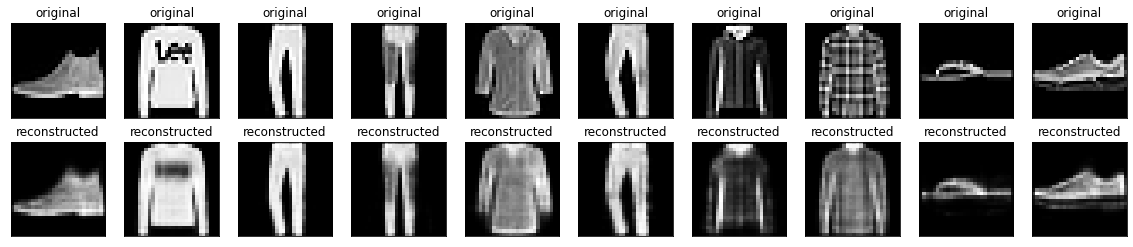

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # Original Image 시각화
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Reconstructed Image 시각화
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(deep_decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

→ Deep한 층을 쌓았을 때 조금 더 복원이 잘 되는 것을 알 수 있다. 